**Part A: Set-up**  
We are choosing Google colab for our project. findspark will be used to set up your local environment to work with Spark, while pyspark is used to write Python code that interacts with Spark.

## Question 1 - Start Spark and get a Spark context

In [ ]:
# print working directory
!pwd

# List files and folders
!ls

# Check the open jdk version on colab
!ls /usr/lib/jvm/

# Run this cell if you are running PySpark on Colab
#Installing java

!apt-get install openjdk-8-jdk-headless -qq > /dev/null

#Downloading latest spark version. 
!wget -q https://archive.apache.org/dist/spark/spark-3.3.2/spark-3.3.2-bin-hadoop2.tgz

#Untar it
!tar xf spark-3.3.2-bin-hadoop2.tgz

#Install pyspark: Adds Pyspark to sys.path at runtime
!pip install -q findspark

# Install pyspark
!pip install pyspark

# set the locations where Spark and Java are installed to let know Colab where to find it
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin-hadoop2"

# Create a spark session: The entry point into all functionality in Spark is the SparkSession class. 

# findspark will locate spark in the system
import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

/content
data.parquet	       spark-3.3.2-bin-hadoop2
drugsCom_raw.zip       spark-3.3.2-bin-hadoop2.tgz
drugsCom_raw.zip.1     spark-3.3.2-bin-hadoop2.tgz.1
drugsCom_raw.zip.2     spark-3.3.2-bin-hadoop2.tgz.2
drugsComTest_raw.tsv   spark-3.3.2-bin-hadoop2.tgz.3
drugsComTrain_raw.tsv  spark-3.3.2-bin-hadoop2.tgz.4
sample_data
java-1.11.0-openjdk-amd64  java-1.8.0-openjdk-amd64
java-11-openjdk-amd64	   java-8-openjdk-amd64
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Load libraries

In [ ]:
# Import necessary libraries

from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace, isnan, when, lit, desc, avg, sum
from pyspark.sql.functions import unix_timestamp, from_unixtime, to_date, date_format

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Question 2 - Download remote CSV dataset

We will be using Drug Review Dataset (https://archive.ics.uci.edu/ml/datasets/Drug+Review+Dataset+%28Drugs.com%29) for our assignment.

In [ ]:
!wget -nc https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip
!unzip  /content/drugsCom_raw.zip

File ‘drugsCom_raw.zip’ already there; not retrieving.

Archive:  /content/drugsCom_raw.zip
replace drugsComTest_raw.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: drugsComTest_raw.tsv    
replace drugsComTrain_raw.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: drugsComTrain_raw.tsv   


## Question 3 - Load the CSV file into a Spark DataFrame

In [ ]:
# read the CSV file
df_train = spark.read.option("header", "true").option("inferSchema", "true").option("sep", "\t").option("quote", "\"").option("escape", "\"").option("multiLine", "true").option("timestampFormat", "mm/dd/yyyy HH:mm:ss").csv("/content/drugsComTrain_raw.tsv")
df_test = spark.read.option("header", "true").option("inferSchema", "true").option("sep", "\t").option("quote", "\"").option("escape", "\"").option("multiLine", "true").option("timestampFormat", "mm/dd/yyyy HH:mm:ss").csv("/content/drugsComTest_raw.tsv")

# Concatenating the train and test data for cleaning
df = df_train.union(df_test)

### Print Schema

In [ ]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- drugName: string (nullable = true)
 |-- condition: string (nullable = true)
 |-- review: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- date: string (nullable = true)
 |-- usefulCount: integer (nullable = true)



### Viewing the Data

In [ ]:
df.show(5)

+------+--------------------+--------------------+--------------------+------+-----------------+-----------+
|   _c0|            drugName|           condition|              review|rating|             date|usefulCount|
+------+--------------------+--------------------+--------------------+------+-----------------+-----------+
|206461|           Valsartan|Left Ventricular ...|"It has no side e...|   9.0|     May 20, 2012|         27|
| 95260|          Guanfacine|                ADHD|"My son is halfwa...|   8.0|   April 27, 2010|        192|
| 92703|              Lybrel|       Birth Control|"I used to take a...|   5.0|December 14, 2009|         17|
|138000|          Ortho Evra|       Birth Control|"This is my first...|   8.0| November 3, 2015|         10|
| 35696|Buprenorphine / n...|   Opiate Dependence|"Suboxone has com...|   9.0|November 27, 2016|         37|
+------+--------------------+--------------------+--------------------+------+-----------------+-----------+
only showing top 5 

## Question 4 - Save the DataFrame to a local Parquet file

In [ ]:
df.write.format("parquet").mode("overwrite").save('/content/data.parquet')

## Question 5 - Load the DataFrame from Parquet file

In [ ]:
df = spark.read.format("parquet").load("/content/data.parquet")
df.show()

+------+--------------------+--------------------+--------------------+------+------------------+-----------+
|   _c0|            drugName|           condition|              review|rating|              date|usefulCount|
+------+--------------------+--------------------+--------------------+------+------------------+-----------+
|206461|           Valsartan|Left Ventricular ...|"It has no side e...|   9.0|      May 20, 2012|         27|
| 95260|          Guanfacine|                ADHD|"My son is halfwa...|   8.0|    April 27, 2010|        192|
| 92703|              Lybrel|       Birth Control|"I used to take a...|   5.0| December 14, 2009|         17|
|138000|          Ortho Evra|       Birth Control|"This is my first...|   8.0|  November 3, 2015|         10|
| 35696|Buprenorphine / n...|   Opiate Dependence|"Suboxone has com...|   9.0| November 27, 2016|         37|
|155963|              Cialis|Benign Prostatic ...|"2nd day on 5mg s...|   2.0| November 28, 2015|         43|
|165907|  

# Part B: Pre-processing

## Question 1 - Perform at least 2 cleaning/wrangling steps

In [ ]:
# Removing '&#039;' from the review column and replacing with apostrophe(')
df = df.withColumn("review", regexp_replace("review", "&#039;", "'"))

# Verifying the column
df.select("review").show()

# replacing quotes
df = df.withColumn("review", regexp_replace("review", '\"', ""))

# Cleaning condition field and replacing <span> strings with 9999
df = df.withColumn('condition', regexp_replace('condition', '\d+</span> users found this comment helpful.', '9999'))

# Rename to UniqueID
df = df.withColumnRenamed("_c0", "uniqueID")

# Converting date field from string type to date type
df = df.select('uniqueID', 'drugName', 'condition', 'review', 'rating', 'usefulCount',
               date_format(to_date('date', 'MMMM d, yyyy'), 'dd-MM-yyyy').alias('review_date'))

df.describe().show()

+--------------------+
|              review|
+--------------------+
|"It has no side e...|
|"My son is halfwa...|
|"I used to take a...|
|"This is my first...|
|"Suboxone has com...|
|"2nd day on 5mg s...|
|"He pulled out, b...|
|"Abilify changed ...|
|" I Ve had  nothi...|
|"I had been on th...|
|"I have been on t...|
|"I have taken ant...|
|"I had Crohn's wi...|
|"Have a little bi...|
|"Started Nexplano...|
|"I have been taki...|
|"This drug worked...|
|"I've been taking...|
|"I've been on eve...|
|"I have been on T...|
+--------------------+
only showing top 20 rows

+-------+------------------+--------------------+-----------+--------------------+------------------+-----------------+-----------+
|summary|          uniqueID|            drugName|  condition|              review|            rating|      usefulCount|review_date|
+-------+------------------+--------------------+-----------+--------------------+------------------+-----------------+-----------+
|  count|            21506

In [ ]:
# Finding null value count for the condition column
df.filter(isnan("condition")).count()


0

In [ ]:
# Verify
df.describe().show()

+-------+------------------+--------------------+-----------+--------------------+------------------+-----------------+-----------+
|summary|          uniqueID|            drugName|  condition|              review|            rating|      usefulCount|review_date|
+-------+------------------+--------------------+-----------+--------------------+------------------+-----------------+-----------+
|  count|            215063|              215063|     213869|              215063|            215063|           215063|     215063|
|   mean|116039.36481403124|                null|     9999.0|                null| 6.990007579174474|28.00100435686287|       null|
| stddev| 67007.91336634514|                null|        0.0|                null|3.2755544975903432| 36.3460688835081|       null|
|    min|                 0|A + D Cracked Ski...|       9999|\n\n please tell ...|               1.0|                0| 01-01-2009|
|    max|            232291|            pHisoHex|zen Shoulde|❤️❤️❤️ Cialis f

In [ ]:
# Finding null value count for condition column
from pyspark.sql.functions import isnan
df.filter(df["condition"].isNull()).count()

1194

In [ ]:
from pyspark.sql.functions import when, lit
df = df.withColumn("condition", \
              when(df["condition"].isNull(), lit('9999')).otherwise(df["condition"]))
df.show()

+--------+--------------------+--------------------+--------------------+------+-----------+-----------+
|uniqueID|            drugName|           condition|              review|rating|usefulCount|review_date|
+--------+--------------------+--------------------+--------------------+------+-----------+-----------+
|  206461|           Valsartan|Left Ventricular ...|It has no side ef...|   9.0|         27| 20-05-2012|
|   95260|          Guanfacine|                ADHD|My son is halfway...|   8.0|        192| 27-04-2010|
|   92703|              Lybrel|       Birth Control|I used to take an...|   5.0|         17| 14-12-2009|
|  138000|          Ortho Evra|       Birth Control|This is my first ...|   8.0|         10| 03-11-2015|
|   35696|Buprenorphine / n...|   Opiate Dependence|Suboxone has comp...|   9.0|         37| 27-11-2016|
|  155963|              Cialis|Benign Prostatic ...|2nd day on 5mg st...|   2.0|         43| 28-11-2015|
|  165907|      Levonorgestrel|Emergency Contrac...|He 

In [ ]:
# Finding null valu count for review column
from pyspark.sql.functions import isnan
df.filter(df["review"].isNull()).count()

0

## Question 2 - Remove unused columns

In [ ]:
#creating new dataframe with just review and rating column
df= df.select("uniqueID", "drugName", "condition", "review", "rating")

## Part C: SparkML and visualization

## Produce a visualisation on a subset of the data

In [ ]:
df_bydrugName = df.groupBy(["drugName","condition"]).agg({'drugName': 'count', "rating": "avg" })
df_bydrugName = df_bydrugName.withColumnRenamed('count(drugName)', 'numReviews')

df_bydrugName.show()
top10_drugs = (
    df_bydrugName.orderBy(desc("numReviews"))
    .limit(10)
    .select("*")
    .toPandas()
    .drop_duplicates(subset=['drugName', 'condition'], keep='first')
)

fig = px.bar(top10_drugs.head(20), x='drugName', y='numReviews',
           hover_data=['avg(rating)','condition'], color='avg(rating)')

fig.show()

+--------------------+--------------------+----------+-----------------+
|            drugName|           condition|numReviews|      avg(rating)|
+--------------------+--------------------+----------+-----------------+
|      Levonorgestrel|       Birth Control|      2884|7.038834951456311|
|    Ortho Tri-Cyclen|       Birth Control|       116|             5.75|
|           Methadone|        Chronic Pain|       108|8.898148148148149|
|          Paroxetine|  Anxiety and Stress|        94|6.787234042553192|
|             Desoxyn|                ADHD|        19|9.631578947368421|
|              Zofran|Nausea/Vomiting, ...|         7|7.285714285714286|
|      Levocetirizine|           Allergies|        97|5.278350515463917|
|      Insulin lispro|    Diabetes, Type 2|         8|              6.0|
|             Emetrol|     Nausea/Vomiting|        21|9.095238095238095|
|          Diflunisal|                Pain|         2|              5.5|
|Ethinyl estradiol...|       Endometriosis|        

Top 10 drugs based on the number of reviews they have received. The chart shows the drug names on the x-axis, the number of reviews on the y-axis, and the color of the bars represents the average rating of each drug. Additionally, hovering over the bars displays the condition associated with the drug and its average rating.

In [ ]:
import random
import plotly.graph_objects as go

colors = ['#%06x' % random.randint(0, 0xFFFFFF) for i in range(10)]
# Generate 10 random colors

df_byCondition = df.groupBy("condition").count()

top10_conditions = (
    df_byCondition.orderBy(desc("count"))
    .limit(10)
    .toPandas()
    .assign(color=colors)
)

fig = go.Figure(data=[go.Bar(
    x=top10_conditions['condition'],
    y=top10_conditions['count'],
    marker_color=top10_conditions['color']
)])

fig.update_layout(xaxis_title='Condition', yaxis_title='Count')
fig.show()


Top 10 medical conditions based on the number of reviews they have received. The chart shows the condition names on the x-axis, the count of reviews on the y-axis

## Perform Sentiment Analysis on Training Data

In [ ]:
print(df.columns)

['uniqueID', 'drugName', 'condition', 'review', 'rating']


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd

df = df.toPandas()
analyzer = SentimentIntensityAnalyzer()

In [ ]:
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def get_vader_score(review):
    return analyzer.polarity_scores(review)['compound']

# Apply the named function to create a new column
df['vaderReviewScore'] = df['review'].apply(lambda x: get_vader_score(x))

# Display the first few rows of the DataFrame
df.head()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


,uniqueID,drugName,condition,review,rating,vaderReviewScore
0,206461,Valsartan,Left Ventricular Dysfunction,"It has no side effect, I take it in combinatio...",9.0,-0.2960
1,95260,Guanfacine,ADHD,My son is halfway through his fourth week of I...,8.0,0.9174
2,92703,Lybrel,Birth Control,"I used to take another oral contraceptive, whi...",5.0,0.6160
3,138000,Ortho Evra,Birth Control,This is my first time using any form of birth ...,8.0,0.7184
4,35696,Buprenorphine / naloxone,Opiate Dependence,Suboxone has completely turned my life around....,9.0,0.9403


In [ ]:
#positive and negative score is assigning based on vaderreview score
pos_num = len(df[df['vaderReviewScore'] >=0.05])
neg_num = len(df[df['vaderReviewScore'] <= 0.05])

In [ ]:
#converitng into 1 or 0 label
df['vaderSentiment']=df['vaderReviewScore'].map(lambda x:int(1) if x>=0.05 else int(0))

In [ ]:
#based on review score divide into positive and negative sentiment
df.loc[df['vaderReviewScore'] >= 0.05,"vadersentimentlabel"] = "positive"
df.loc[df['vaderReviewScore'] <= 0.05,"vadersentimentlabel"] = "negative"

# rating based on rating column
pos_rating = len(df[df['rating'] >= 5])
neg_rating = len(df[df['rating'] <= 5])

In [ ]:
#if rating is more that 5 consider it as label 1 else 0
df['ratingsentiment']=df['rating'].map(lambda x:int(1) if x>=5 else int(0))

In [ ]:
#assigning positive and negative rating based on start rating
df.loc[df['rating'] >= 5,"ratingsentimentlabel"] = "positive"
df.loc[df['rating'] <= 5,"ratingsentimentlabel"] = "negative"

In [ ]:
#dispalying the dataframe with review ,rating and with both label
df.head()

,uniqueID,drugName,condition,review,rating,vaderReviewScore,vaderSentiment,vadersentimentlabel,ratingsentiment,ratingsentimentlabel
0,206461,Valsartan,Left Ventricular Dysfunction,"It has no side effect, I take it in combinatio...",9.0,-0.2960,0,negative,1,positive
1,95260,Guanfacine,ADHD,My son is halfway through his fourth week of I...,8.0,0.9174,1,positive,1,positive
2,92703,Lybrel,Birth Control,"I used to take another oral contraceptive, whi...",5.0,0.6160,1,positive,1,negative
3,138000,Ortho Evra,Birth Control,This is my first time using any form of birth ...,8.0,0.7184,1,positive,1,positive
4,35696,Buprenorphine / naloxone,Opiate Dependence,Suboxone has completely turned my life around....,9.0,0.9403,1,positive,1,positive


## Using NLTK, creating pipeline

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
#calculating inverse TF based on review column
tfidf = TfidfVectorizer(stop_words='english',ngram_range=(1,4))
features = tfidf.fit_transform(df.review)
labels = df.vaderSentiment

## Apply a ML algorithm of your choice to your data

### Creating models using different classifiers

In [ ]:
#importing machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
#spliting feature and label variable in to train and test catagory
x_train,x_test,y_train,y_test = train_test_split(df['review'],df['ratingsentimentlabel'],random_state=0)

In [ ]:
#importing different type of classifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

In [ ]:
#creating model based on linearSVC, LogisticRegresssion Regression 
models = [LinearSVC(), LogisticRegression(random_state=0,solver='lbfgs',max_iter=2000,multi_class='auto')]
CV = 4
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model,features,labels,scoring='accuracy',cv=CV)
  for fold_idx,accuracy in enumerate(accuracies):
    entries.append((model_name,fold_idx,accuracy))
cv_df = pd.DataFrame(entries,columns=['model_name','fold_idx','accuracy'])

In [ ]:
#displaying accuracy for each model for 5 fold iteration 
cv_df

,model_name,fold_idx,accuracy
0,LinearSVC,0,0.927966
1,LinearSVC,1,0.930235
2,LinearSVC,2,0.929658
3,LinearSVC,3,0.928001
4,LogisticRegression,0,0.881114
5,LogisticRegression,1,0.883160
6,LogisticRegression,2,0.880315
7,LogisticRegression,3,0.879959


In [ ]:
#showing based model accuracy
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC             0.928965
LogisticRegression    0.881137
Name: accuracy, dtype: float64

LinearSVC has the highest accuracy of 92.89 percentage.

### Creating the final model for prediction using the best model (SVM) and training the model

In [ ]:
#importing normalizer for predicting input
from sklearn.preprocessing import Normalizer
#as SVC is proven for best model based on accuracy will run prediction based on that
model = LinearSVC('l2')

# Create test and train data
x_train,x_test,y_train,y_test = train_test_split(features,labels,test_size=0.25,random_state=0)
normalize = Normalizer()
x_train = normalize.fit_transform(x_train)
x_test = normalize.transform(x_test)

### Fit the model and predict

In [ ]:
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,y_pred))

0.9308484916117993


<Figure size 1200x1200 with 0 Axes>

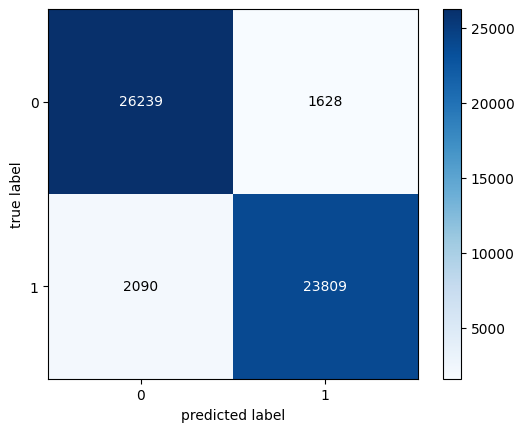

In [ ]:
#creating confusion matrix for test and predicted output
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test,y_pred)
#imporing MLxtend library for ploting confusion matrix
from mlxtend.plotting import plot_confusion_matrix

#displaying confusion matrix
fig = plt.figure(figsize=(12,12))
fig,ax = plot_confusion_matrix(conf_mat=conf_mat,colorbar=True)
# fig.savefig("confusion.png")

In [ ]:
#summary table of SVC model
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred,target_names=df['ratingsentimentlabel'].unique()))

              precision    recall  f1-score   support

    positive       0.93      0.94      0.93     27867
    negative       0.94      0.92      0.93     25899

    accuracy                           0.93     53766
   macro avg       0.93      0.93      0.93     53766
weighted avg       0.93      0.93      0.93     53766



The precision for the "positive" class is 0.93, which means that out of all the examples that were classified as "positive", 93% were actually positive. The recall for the "positive" class is 0.94, which means that out of all the actual positive examples, 94% were correctly identified as positive. The F1-score for the "positive" class is 0.93, which is the harmonic mean of precision and recall.

Similarly, for the "negative" class, the precision is 0.94, the recall is 0.92, and the F1-score is 0.93. These metrics indicate that the classifier is performing well for both classes, with similar scores for both.

The overall accuracy of the classifier is 0.93, which means that it correctly classified 93% of the examples in the dataset. 